" AI II "

Master Language Tecnology

Name: Antonakaki Eleni

AM: Lt1200002


**1. Import all necessery libraries**

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import torch.optim as optim
from torchtext import data
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import re
import spacy
import seaborn as sns
from tqdm import tqdm
import pickle
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [2]:
def set_seed(seed):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(25)

In [3]:
#set device

cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")

torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cpu


In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**2 a) Load train data as dataframe**


In [5]:
#loading the data
tweets_train = pd.read_csv("vaccine_train_set.csv")
print(tweets_train.shape)
tweets_train.head()

(15976, 3)


,Unnamed: 0,tweet,label
0,0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,1,I don't know about you but My family and I wil...,1
2,2,@MSignorile Immunizations should be mandatory....,2
3,3,President Obama spoke in favor of vaccination ...,0
4,4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


label
0    7458
1    2073
2    6445
dtype: int64


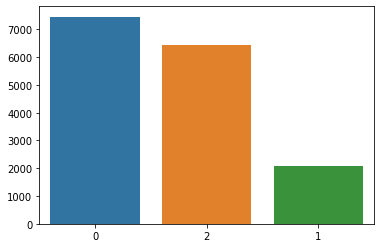

In [6]:
#analysing labels

print(tweets_train.groupby(['label']).size())

dd = pd.Series(tweets_train['label']).value_counts()
sns.barplot(x=np.array(['0','2','1']),y= dd.values)
plt.show()

 **2 b) Load validation data as dataframe**

In [7]:
tweets_val = pd.read_csv("vaccine_validation_set.csv")
print(tweets_val.shape)
tweets_val.head()

(2282, 3)


,Unnamed: 0,tweet,label
0,0,@user They had a massive surge in with covid d...,1
1,1,Required vaccines for school: Parents and guar...,0
2,2,“@KCStar: Two more Johnson County children hav...,0
3,3,NV can do better. Which states are the best (a...,2
4,4,Nothing like killing ourselves w/ our own fear...,2


**3. Processing**

1. remove punctuation
2. remove emoticons
3. lowercasing
4. remove stopwords
5. Porter Stemmer

In [8]:
#process data

tweets_train['tweet'].fillna('')

def preprocess_text(text):
                
        TAG_RE = re.compile(r'<[^>]+>_-@')
        no_tags = TAG_RE.sub('',text) 
        text = re.sub('<[^>]*>_@-', '', no_tags)        
        text = re.sub('_','',text) 
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
        text = re.sub('[\W]+', ' ', text.lower()) + " ".join(emoticons).replace('-', '')
        text = re.sub(r'\d+', '', text)

        return text

def remove_stopwords(text):

    text = nltk.word_tokenize(text)
    text = [w for w in text if not w in stop_words]
    #text= ' '.join(text)
      
    return text


stop_words = set(stopwords.words('english'))

stemming = PorterStemmer()
def porterstemmer(text):
    return " ".join([stemming.stem(w) for w in text])


In [9]:
#process on train data
tweets_train['tweet']=tweets_train['tweet'].apply(preprocess_text)
tweets_train['tweet']=tweets_train['tweet'].apply(remove_stopwords)
tweets_train['tweet']= tweets_train['tweet'].apply(porterstemmer).copy()

tweets_train.head()

,Unnamed: 0,tweet,label
0,0,sip n shop come thru right marjai popularnobod...,0
1,1,know famili take covid vaccin anytim soon,1
2,2,msignoril immun mandatori period oklahoma let ...,2
3,3,presid obama spoke favor vaccin children fox s...,0
4,4,myfoxla arizona monitor hundr measl link disne...,0


In [10]:
#process on validation data
tweets_val['tweet']=tweets_val['tweet'].apply(preprocess_text)
tweets_val['tweet']=tweets_val['tweet'].apply(remove_stopwords)
tweets_val['tweet']= tweets_val['tweet'].apply(porterstemmer).copy()

tweets_val.head()

,Unnamed: 0,tweet,label
0,0,user massiv surg covid death immedi vaccin rol...,1
1,1,requir vaccin school parent guardian children ...,0
2,2,kcstar two johnson counti children measl http ...,0
3,3,nv better state best worst vaccin kid http co ...,2
4,4,noth like kill w fear mt alyssamilano vaccin f...,2


In [11]:
#define X and y values for train and validation dataset
X_train = tweets_train["tweet"]
y_train = tweets_train["label"]
X_val = tweets_val["tweet"]
y_val = tweets_val["label"]


print("x_train's shape:", X_train.shape)
print("x_val's shape:", X_val.shape)
print("=========================")
print("y_train's shape:", y_train.shape)
print("y_val's shape:", y_val.shape)

train = pd.concat([X_train, y_train], axis=1)
#print(train.shape)

valid = pd.concat([X_val, y_val], axis=1)
#print(valid.shape)

x_train's shape: (15976,)
x_val's shape: (2282,)
y_train's shape: (15976,)
y_val's shape: (2282,)


**Use torchtext library for dataset and build vocab**

> *Field* for preprocessing

> *TabularDataset* for loading the train and validation data (csv file)

> *BucketIterator* for batching and padding

In [12]:
#calculate mean and maximum sequence length of train dataset

tweets_list=[]
for x in tweets_train['tweet']:
  tweets_list.append(x)

print(np.max([len(x) for x in tweets_list]))
print(np.mean([len(x) for x in tweets_list]))
#print(len(tweets_list[1]))

627
78.69767150726089


In [13]:
TEXT = torchtext.legacy.data.Field(dtype=torch.long,sequential=True, tokenize="spacy",batch_first=True)
#Sequential= whether the datatype represents sequential data.
#Batch_first=  Whether to produce tensors with the batch dimension first.
LABEL = torchtext.legacy.data.LabelField(dtype=torch.long, sequential=False)

os.mkdir('dataset')
train.to_csv("/content/dataset/train.csv", index=False)
valid.to_csv("/content/dataset/valid.csv", index=False)

train_data, valid_data = torchtext.legacy.data.TabularDataset.splits( 
    path="/content/dataset/", 
    train="train.csv", 
    validation="valid.csv", 
    format="csv", 
    skip_header=True, 
    fields=[('tweet', TEXT), ('label', LABEL)])

print(f'Number of training samples: {len(train_data)}')
print(f'Number of validation samples: {len(valid_data)}')

Number of training samples: 15976
Number of validation samples: 2282


In [14]:
TEXT.build_vocab(train_data, valid_data, vectors=torchtext.vocab.Vectors("/content/glove.twitter.27B.100d.txt"),max_size=30000, min_freq=1)
LABEL.build_vocab(train_data)

#vocab_size= len(TEXT.vocab)
print(f"Unique tokens in TEXT vocab: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocab: {len(LABEL.vocab)}")
#print(TEXT.vocab.vectors[TEXT.vocab.stoi['good']])

Unique tokens in TEXT vocab: 29838
Unique tokens in LABEL vocab: 3


In [15]:
os.mkdir('Glove_dictionary')

# Save GloVe dictionary.
#texts
vocab_tweets_f = open("/content/Glove_dictionary/vocab_tweets.pkl", "wb")
pickle.dump(TEXT.vocab,vocab_tweets_f)
vocab_tweets_f.close()

#labels
vocab_labels_f = open("/content/Glove_dictionary/vocab_labels.pkl", "wb")
pickle.dump(LABEL.vocab,vocab_labels_f)
vocab_labels_f.close()

# Load GloVe dictionary.
#tweets
vocab_tweets_f = open("/content/Glove_dictionary/vocab_tweets.pkl", "rb")
vocab_tweets = pickle.load(vocab_tweets_f)

#labels
vocab_labels_f = open("/content/Glove_dictionary/vocab_labels.pkl", "rb")
vocab_labels = pickle.load(vocab_labels_f)
# glove_file.close()

In [16]:
BATCH_SIZE = 64

#Defines an iterator that batches examples of similar lengths together.
# Sort key= sorting examples in order to batch together examples with similar lengths and minimize padding. 
train_iterator, valid_iterator = torchtext.legacy.data.BucketIterator.splits(
    (train_data, valid_data), 
    sort_key=lambda x: len(x.tweet),
    batch_size=BATCH_SIZE,
    shuffle=True,
    device=device)

# Print number of batches per dataset.
print('Created `train_iterator` with %d batches!'%len(train_iterator))
print('Created `valid_iterator` with %d batches!'%len(valid_iterator))

Created `train_iterator` with 250 batches!
Created `valid_iterator` with 36 batches!


In [17]:
word_embeddings = vocab_tweets.vectors
#print(word_embeddings[3])

vocab_size= len(TEXT.vocab)
print(vocab_size)

29838


4. **Define cells**

    a) LSTM cell

    b) GRU cell


In [18]:
class SentimentRNN(nn.Module):
   def __init__(self, cell_type, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, word_embeddings, dropout_layers, bidirectional):
        super(SentimentRNN, self).__init__()
        
        cells = { "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU}   

        self.output_size = output_size
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type
        self.dropout_layers = dropout_layers
        self.bidirectional = bidirectional

        #embedding_layer
        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.word_embeddings.weight = torch.nn.Parameter(word_embeddings, requires_grad= False)

        #LSTM or GRU basic cell
        if cell_type == 'LSTM':
           self.nn = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_dim, num_layers=self.n_layers, bidirectional=self.bidirectional, batch_first=True)
        elif cell_type == 'GRU':
           self.nn = nn.GRU(input_size=self.embedding_dim, hidden_size=self.hidden_dim, num_layers=self.n_layers, bidirectional=self.bidirectional, batch_first=True)
        else:
            raise Exception("[Error] Unknown cell type. Currently supported: LSTM, GRU")

        #first dropout layer
        if self.dropout_layers >= 1:
            self.dropout_one = torch.nn.Dropout(0.4)

        #linear(dense) layer
        if self.bidirectional == True:
           self.linear = torch.nn.Linear(hidden_dim*2, 36)
        else:
           self.linear = torch.nn.Linear(hidden_dim, 36)
           
        #second dropout layer
        if self.dropout_layers == 2:
           self.dropout_two = torch.nn.Dropout(0.3)

        #second linear layer
        self.linear2 = torch.nn.Linear(36, output_size)

        #activation function softmax
        #self.softmax = nn.Softmax(dim=0)

        
   def forward(self, x, hidden):

        batch_size = x.size(0)
        x = self.word_embeddings(x)

        out, hidden = self.nn(x, hidden)

        if self.bidirectional == True: 
          out = out.contiguous().view(-1, self.hidden_dim*2)
        else:
          out = out.contiguous().view(-1, self.hidden_dim)

        if self.dropout_layers >=1:
           out = self.dropout_one(out)

        out = self.linear(out)   

        if self.dropout_layers == 2:
           out = self.dropout_two(out)

        #out= self.softmax(out)
        out = self.linear2(out)
        #print(out.size())
      
        #take only the last batch
        out = out.view(batch_size, -1, output_size)
        out = out[:, -1, :]
        #out  = F.log_softmax(out, dim=1)

 
        return out.to(device), hidden


   def init_hidden(self, batch_size):

        #initialize hidden_states with zero(0)
        weight = next(self.parameters()).data
        
        if self.bidirectional == True:
           if self.cell_type == 'LSTM':
              hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().to(device),
                        weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().to(device))
           elif self.cell_type == 'GRU':
              hidden = weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().to(device)
        else:
           if self.cell_type == 'LSTM':
              hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
           elif self.cell_type == 'GRU':
              hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)

        

        
        return hidden


In [19]:
#hyperparameters 
learning_rate = 0.001
batch_size = 64
output_size = 3
num_layers = 2
hidden_size = 64
embedding_dim = 100
dropout_layers= 2

#cell_type options
#cell_type='GRU'
cell_type='LSTM'

#define model
model = SentimentRNN(cell_type, vocab_size=vocab_size, output_size=output_size, embedding_dim=embedding_dim, hidden_dim=hidden_size, n_layers=num_layers,word_embeddings=word_embeddings, dropout_layers= dropout_layers, bidirectional= True)
model.to(device)
print(model)

#define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss().to(device)

SentimentRNN(
  (word_embeddings): Embedding(29838, 100, padding_idx=0)
  (nn): LSTM(100, 64, num_layers=2, batch_first=True, bidirectional=True)
  (dropout_one): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=128, out_features=36, bias=True)
  (dropout_two): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=36, out_features=3, bias=True)
)


In [20]:
#save the model
torch.save(model.state_dict(), 'model.pkl')

**5. TRAIN AND EVALUATION**

In [21]:
def train_model(model, iterator, optimizer, loss_function, max_norm, cell_type, batch_size):
  
  epoch_loss = 0
  epoch_acc=[]
  epoch_f1=[]
  epoch_precision=[]
  epoch_recall=[]
  
  model.train()
  hidden_st = model.init_hidden(batch_size)
  
  for batch in iterator:

    if cell_type == 'LSTM':
      hidden_st = tuple([each.data for each in hidden_st])
    elif cell_type == 'GRU':
      hidden_st.detach_()
      hidden_st = hidden_st.detach()

    inputs = batch.tweet.to(device)
    labels = batch.label.to(device)
    
    if inputs.shape[0] == batch_size:
    
      optimizer.zero_grad()
      #print(len(inputs))
      
      predictions, hidden_st = model.forward(inputs, hidden_st)
      
      loss = loss_function(predictions, labels)
      loss.backward()
 
      epoch_loss += loss.item()

      nn.utils.clip_grad_norm_(model.parameters(), max_norm)

      #print(type(prediction))
      #print(type(labels))

      # ===== METRICS FOR TRAIN SET ==========
      _, predicted = torch.max(predictions.data, 1)
      predicted = predicted.to("cpu").tolist()
      epoch_acc.append(accuracy_score(predicted, labels.tolist()))
      epoch_f1.append(f1_score(predicted, labels.tolist(), average='macro'))
      epoch_precision.append(precision_score(predicted, labels.tolist(), average='macro'))
      epoch_recall.append(recall_score(predicted, labels.tolist(), average='macro', zero_division=0))

      optimizer.step()
  
  
  return epoch_loss / len(iterator), sum(epoch_acc)/len(epoch_acc), sum(epoch_f1)/len(epoch_f1), sum(epoch_precision)/len(epoch_precision), sum(epoch_recall)/len(epoch_recall)

In [22]:
def model_eval(model, iterator, loss_function, cell_type, batch_size):
  
  val_epoch_loss = 0
  val_epoch_acc = []
  val_epoch_f1=[]
  val_epoch_precision=[]
  val_epoch_recall=[]
  
  model.eval()
  hidden_st = model.init_hidden(batch_size)

  with torch.no_grad():
  
    for batch in iterator:
      
      if cell_type == 'LSTM':
        hidden_st = tuple([each.data for each in hidden_st])
      elif cell_type == 'GRU':
        hidden_st.detach_()
        hidden_st = hidden_st.detach()

      x_val = batch.tweet.to(device)
      y_val = batch.label.to(device)


      if x_val.shape[0] == batch_size:

        predictions, hidden_st = model.forward(x_val, hidden_st)
        
        loss_val = loss_function(predictions, y_val)
        val_epoch_loss += loss_val.item()

        # ===== METRICS FOR VALIDATION SET ==========
        _, predicted = torch.max(predictions.data, 1)
        predicted = predicted.to("cpu").tolist()
        val_epoch_acc.append(accuracy_score(predicted, y_val.tolist()))
        val_epoch_f1.append(f1_score(predicted, y_val.tolist(), average='macro'))
        val_epoch_precision.append(precision_score(predicted, y_val.tolist(), average='macro'))
        val_epoch_recall.append(recall_score(predicted, y_val.tolist(), average='macro', zero_division=0))
        
        
      
  return val_epoch_loss / len(iterator), sum(val_epoch_acc)/len(val_epoch_acc), sum(val_epoch_f1)/len(val_epoch_f1), sum(val_epoch_precision)/len(val_epoch_precision), sum(val_epoch_recall)/len(val_epoch_recall)

In [23]:
#set hyperparameters

#LSTM cell
num_epochs= 10
clip= 3 #for regularization

#GRU cell
#num_epochs=5
#clip= 5
batch_size= 64

#rnn cell type
cell_type= 'LSTM'
#cell_type= 'GRU'



train_loss=[]
train_accuracy=[]
val_loss=[]
val_accuracy=[]
index= 0
for epoch in range(num_epochs):
  loss_train, acc_train, f1_train, precision_train, recall_train = train_model(model, train_iterator, optimizer, loss, clip, cell_type, batch_size)
  valid_loss, val_acc, val_f1, val_precision, val_recall = model_eval(model, valid_iterator, loss, cell_type, batch_size)
  index +=1

  train_loss.append(loss_train)
  train_accuracy.append(acc_train)
  val_loss.append(valid_loss)
  val_accuracy.append(val_acc)

  print(f' EPOCH: {index} -> Train Loss: {loss_train:.3f},  Acc train: {acc_train: .3f},  F1 train: {f1_train: .3f}, Precision train: {precision_train: .3f}, Recall train: {recall_train: .3f}, Val Loss: {valid_loss:.3f},  Acc valid: {val_acc: .3f},  F1 valid: {val_f1: .3f}, Precision valid: {val_precision: .3f}, Recall valid: {val_recall: .3f}')


 EPOCH: 1 -> Train Loss: 0.973,  Acc train:  0.484,  F1 train:  0.308, Precision train:  0.362, Recall train:  0.313, Val Loss: 1.010,  Acc valid:  0.462,  F1 valid:  0.273, Precision valid:  0.369, Recall valid:  0.379
 EPOCH: 2 -> Train Loss: 0.917,  Acc train:  0.573,  F1 train:  0.400, Precision train:  0.438, Recall train:  0.399, Val Loss: 1.081,  Acc valid:  0.449,  F1 valid:  0.375, Precision valid:  0.424, Recall valid:  0.451
 EPOCH: 3 -> Train Loss: 0.950,  Acc train:  0.514,  F1 train:  0.312, Precision train:  0.383, Recall train:  0.316, Val Loss: 1.009,  Acc valid:  0.482,  F1 valid:  0.303, Precision valid:  0.386, Recall valid:  0.424
 EPOCH: 4 -> Train Loss: 0.888,  Acc train:  0.597,  F1 train:  0.426, Precision train:  0.458, Recall train:  0.439, Val Loss: 0.990,  Acc valid:  0.501,  F1 valid:  0.324, Precision valid:  0.401, Recall valid:  0.405
 EPOCH: 5 -> Train Loss: 0.885,  Acc train:  0.598,  F1 train:  0.431, Precision train:  0.463, Recall train:  0.454, Va

**6. LEARNING CURVES**

(plot loss & accuracy for train and validation set)

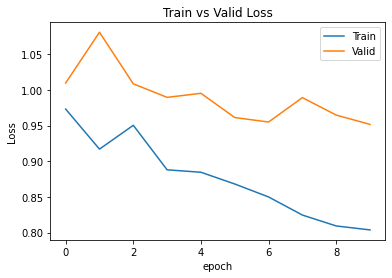

In [24]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.show()

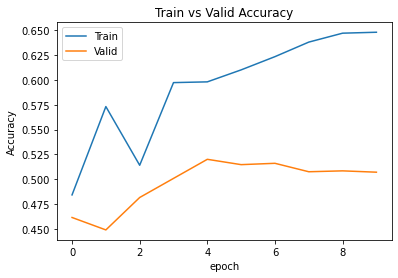

In [25]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

**7. ROC CURVE**

In [26]:
def Roc_curve(y_true,y_pred):

    y = label_binarize(y_true, classes=[0, 1, 2])
    n_classes = y.shape[1]
    lw = 2


    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")

    return plt.show()

**8. PREDICTIONS ON TEST SET**

In [27]:
#PREPROCESS ON THE TEST SET

tweets_test = pd.read_csv("vaccine_validation_set.csv")
print("Test set shape:", tweets_test.shape)

tweets_test['tweet']=tweets_test['tweet'].apply(preprocess_text)
tweets_test['tweet']=tweets_test['tweet'].apply(remove_stopwords)
tweets_test['tweet']= tweets_test['tweet'].apply(porterstemmer).copy()
print("Preprocess done")

X_test = tweets_test["tweet"]
y_test = tweets_test["label"]
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

test = pd.concat([X_test, y_test], axis=1)
test.to_csv("/content/dataset/test.csv", index=False)
print("test set has been downloaded ")

test_data = torchtext.legacy.data.TabularDataset( 
    path="/content/dataset/test.csv", 
    format="csv", 
    skip_header=True, 
    fields=[('tweet', TEXT), ('label', LABEL)])


print(f'Number of testing samples: {len(test_data)}')

TEXT.build_vocab(test_data, vectors=torchtext.vocab.Vectors("/content/glove.twitter.27B.100d.txt"),max_size=20000, min_freq=3)
LABEL.build_vocab(train_data)

vocab_size= len(TEXT.vocab)
print("===============================================")
print(f"Unique tokens in TEXT (test) vocab: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL (test) vocab: {len(LABEL.vocab)}")

test_iterator = torchtext.legacy.data.BucketIterator(
    test_data, 
    sort_key=lambda x: len(x.tweet),
    batch_size=BATCH_SIZE,
    shuffle=True,
    device=device)

# Print number of batches per dataset.
print("===============================================")
print('Created `test_iterator` with %d batches!'%len(test_iterator))

Test set shape: (2282, 3)
Preprocess done
x_test shape: (2282,)
y_test shape: (2282,)
test set has been downloaded 
Number of testing samples: 2282
Unique tokens in TEXT (test) vocab: 1500
Unique tokens in LABEL (test) vocab: 3
Created `test_iterator` with 36 batches!


In [28]:
def evaluation_test(model, iterator, batch_size):
  model.eval()
  h = model.init_hidden(batch_size)

  test_accuracy=[]
  test_f1=[]
  test_precision=[]
  test_recall=[]
  predictions_list=[]
  y_test_list=[]
  prediction_list=[]
  with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_iterator)):
      if model.cell_type == 'LSTM':
        h = tuple([e.data for e in h])
      elif model.cell_type == 'GRU':
        h.detach_()
        h = h.detach()

      x_test = batch.tweet
      y_test = batch.label
      y_test = y_test.type(torch.LongTensor)

      x_test = x_test.to(device)
      y_test = y_test.to(device)

      if x_test.shape[0] == batch_size:
        

          prediction, h = model(x_test, h)
      

          _, predicted = torch.max(prediction, 1)
          predicted = predicted.to("cpu").tolist()
          predictions_list.append(predicted)
          y_test_list.append(y_test.tolist())
          test_accuracy.append(accuracy_score(predicted, y_test.tolist()))
          test_f1.append(f1_score(predicted, y_test.tolist(), average='weighted'))
          test_precision.append(precision_score(predicted, y_test.tolist(),  average='weighted'))
          test_recall.append(recall_score(predicted, y_test.tolist(),  average='weighted', zero_division=0))
  
  roc_curve = Roc_curve(y_test,prediction)

  return test_accuracy, test_f1, test_precision, test_recall, predictions_list, y_test_list, roc_curve
   

100%|██████████| 36/36 [00:01<00:00, 30.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


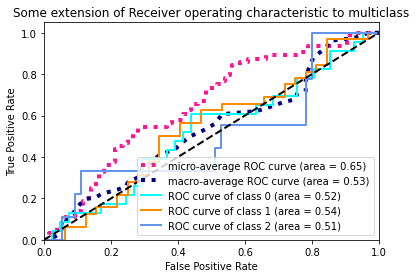



 Accuracy on test set: 47.410714285714285


 F1 score on test set: 49.95427467554566


 Precision on test set: 56.013289412446646


 Recall on test set: 47.410714285714285


In [29]:
test_accuracy, test_f1, test_precision, test_recall, predictions_list, y_test_list, roc_curve = evaluation_test(model, test_iterator, batch_size)

accuracy= np.mean(test_accuracy)
f1 = np.mean(test_f1)
precision = np.mean(test_precision)
recall = np.mean(test_recall)


#print metrics on test set
print(f'\n\n Accuracy on test set:', accuracy*100)
print(f'\n\n F1 score on test set:', f1*100)
print(f'\n\n Precision on test set:', precision*100)
print(f'\n\n Recall on test set:', recall*100)


In [30]:
preds=[]
actual_y=[]

for batches_test in predictions_list:
  for batch_test in batches_test:
      preds.append(batch_test)

for batches in y_test_list:
  for batch in batches:
     actual_y.append(batch)

target_names=['0','2','1']
print(classification_report(actual_y,preds,target_names=target_names))

              precision    recall  f1-score   support

           0       0.54      0.45      0.49      1044
           2       0.45      0.64      0.53       904
           1       0.15      0.04      0.06       292

    accuracy                           0.47      2240
   macro avg       0.38      0.38      0.36      2240
weighted avg       0.45      0.47      0.45      2240

